In [8]:
# imports
import numpy as np
# import pandas as pd
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


import matplotlib.pyplot as plt
from PIL import Image

import math

In [9]:
mask_path = '../data/road_seg/training/gt_image_2'
img_path = '../data/road_seg/training/image_2'
test_path = '../data/road_seg/testing'

# Number of training examples
training_set_size = int(len(os.listdir(img_path)) * 0.75)
print(f"Number of Training Examples: {training_set_size}")

validation_set_size = int(len(os.listdir(img_path)) * 0.15)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = int(len(os.listdir(img_path)) -
                    training_set_size - validation_set_size)
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 216
Number of Validation Examples: 43
Number of Testing Examples: 30


In [10]:
def load_images(path, mask=False):
    result = []
    images = os.listdir(path)
    if mask == True:
        images = [entry for entry in images if "road" in entry]
    images = sorted(images)  # sort file names in ascending order

    # print(images)
    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_im = im.resize((64, 64))
        res = np.asarray(resized_im)
        result.append(res)
    return np.array(result)

In [11]:
def show_images(images, num_images_to_show):
    fig = plt.figure()
    for i in range(1, num_images_to_show+1):
        fig.add_subplot(1, num_images_to_show, i)
        img = images[i-1, :]
        plt.imshow(img)

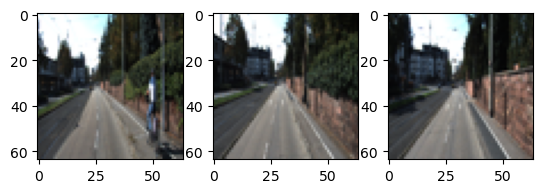

In [12]:
data=load_images(img_path,mask=False)
show_images(data, 3)

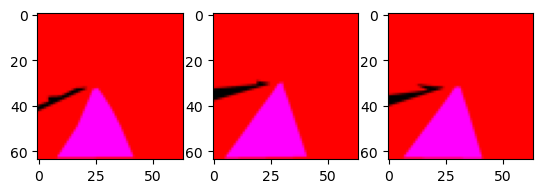

In [13]:
true_mask = load_images(mask_path, mask=True)
show_images(true_mask, 3)

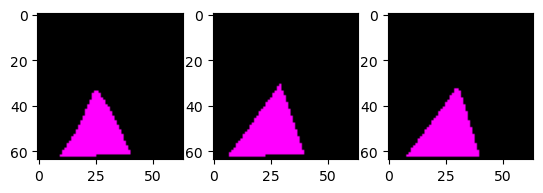

In [14]:
def convert_to_binary_mask(true_mask):
    binary_mask = []
    for i in range(len(true_mask)):
        # convert all masks to just binary masks (road and no road)
        road_label = np.array([255, 0, 255])
        cond = np.all(true_mask[i] == road_label, axis=2)
        binary_mask.append(true_mask[i] * cond[..., np.newaxis])
        
    return np.array(binary_mask)
        
binary_mask = convert_to_binary_mask(true_mask)
show_images(binary_mask, 3)

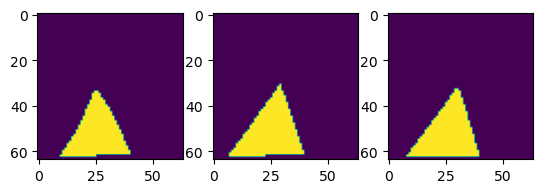

In [15]:
rgb_mask=np.dot(binary_mask[..., :3], [0.2989, 0.5870, 0.1140]) # RGB conversion
rgb_mask=np.expand_dims(rgb_mask, axis=-1)
show_images(rgb_mask, 3)

In [16]:
# range: [0, 1] -> normalization
rgb_mask[rgb_mask != 0.0] = 1.0
data = data / 255.0

## Data Augmentation

In [17]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2,
                  saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),
])

print(f'Data shape: {data.shape}')
print(f'Mask shape: {rgb_mask.shape}')

data=data.astype(np.float32)
rgb_mask=rgb_mask.astype(np.float32)

Data shape: (289, 64, 64, 3)
Mask shape: (289, 64, 64, 1)


/home/abhi/.local/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [18]:
test_augmentation = augmentation_pipeline(image=data[5], mask=rgb_mask[5])
test_image = test_augmentation["image"]
test_mask = test_augmentation["mask"]

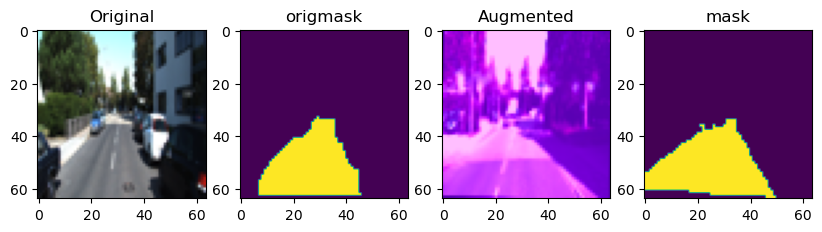

In [19]:
# Show original and augmented images side by side
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[4])
ax[0].set_title("Original")

ax[1].imshow(rgb_mask[4])
ax[1].set_title("origmask")


ax[2].imshow(test_image)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()

In [20]:
new_imgs = 10

# time taken to run this iteration: 3m 35.0s
for i in range(len(data)):
    for j in range(new_imgs):
        image = data[i]
        mask = rgb_mask[i]

        augmentation = augmentation_pipeline(image=image, mask=mask)
        augmentated_image = augmentation["image"]
        augmentated_mask = augmentation["mask"]
        data = np.vstack((data, augmentated_image[np.newaxis, ...]))
        rgb_mask = np.vstack((rgb_mask, augmentated_mask[np.newaxis, ...]))

print(f'Augmented data shape: {data.shape}')
print(f'Augmented mask shape: {rgb_mask.shape}')

Augmented data shape: (3179, 64, 64, 3)
Augmented mask shape: (3179, 64, 64, 1)


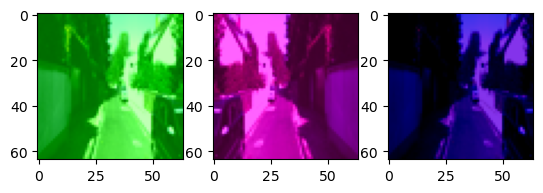

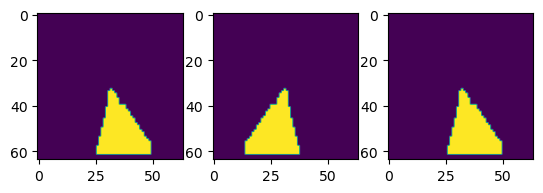

In [21]:
show_images(data[-24:], 3)
show_images(rgb_mask[-24:], 3)

In [22]:
# recalculating batch sizes
training_set_size = int(len(data) * 0.75)
print(f"Number of Augmented Training Examples: {training_set_size}")

validation_set_size = int(len(data) * 0.15)
print(f"Number of Augmented Validation Examples: {validation_set_size}")

test_set_size = int(len(data) - training_set_size - validation_set_size)
print(f"Number of Augmented Testing Examples: {test_set_size}")

Number of Augmented Training Examples: 2384
Number of Augmented Validation Examples: 476
Number of Augmented Testing Examples: 319


In [23]:
X_test = data[:test_set_size].transpose((0, 3, 1, 2))
y_test = rgb_mask[:test_set_size].transpose((0, 3, 1, 2))
print(f'test set size {X_test.shape}')

# rest of the data will be agumented and shuffled for training
data = data[test_set_size:]
rgb_mask = rgb_mask[test_set_size:]

# Shuffle the indices
shuffled_indices = np.random.permutation(len(data))

# Use the shuffled indices to shuffle both arrays
shuffled_data = data[shuffled_indices]
shuffled_masks = rgb_mask[shuffled_indices]

test set size (319, 3, 64, 64)


In [24]:
# train_test_validation split
X_train = shuffled_data[:training_set_size].transpose((0, 3, 1, 2))
y_train = shuffled_masks[:training_set_size] #.transpose((0, 3, 1, 2))
print(f'training set size {X_train.shape}')

X_val = shuffled_data[training_set_size:training_set_size +
                      validation_set_size].transpose((0, 3, 1, 2))
y_val = shuffled_masks[training_set_size:training_set_size +
                       validation_set_size].transpose((0, 3, 1, 2))
print(f'val set size {X_val.shape}')

training set size (2384, 3, 64, 64)
val set size (476, 3, 64, 64)


In [25]:
class ImageDataset(Dataset):
    '''
    Prepare an image dataset
    '''

    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]
        return img, mask


# creating dataset
train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# creating the dataloader object
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## U-Net Implementation

In [26]:
class DoubleConv(nn.Module):
    '''
    '''

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

In [27]:
class UNet(nn.Module):
    '''
    '''

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.upscale = nn.ModuleList()
        self.downscale = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # downscaling
        for feature in features:
            self.downscale.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # upscaling
        for feature in reversed(features):
            self.upscale.append(nn.ConvTranspose2d(
                feature*2, feature, kernel_size=2, stride=2))
            self.upscale.append(DoubleConv(feature*2, feature))

        self.left_over = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for layer in self.downscale:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.left_over(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.upscale), 2):
            skip_connection = skip_connections[idx//2]
            x = self.upscale[idx](x)

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.upscale[idx+1](concat_skip)
            
        return torch.sigmoid(self.final_conv(x))

In [28]:
class IoULoss(nn.Module):
    '''
    '''

    def __init__(self):
        super(IoULoss, self).__init__()
        self.smoothness = 1e-6  # avoid zero division error

    def forward(self, y_pred, y):
        y_pred = y_pred.view(-1)
        y = y.view(-1)
        intersection = (y_pred * y).sum()
        union = y_pred.sum() + y.sum() - intersection

        iou = intersection / (union + self.smoothness)
        return 1 - iou

In [29]:
num_epochs = 100
# torch.cuda.empty_cache()
device = torch.device("cpu")
loss_fn = IoULoss().to(device)

learning_rate = 0.001
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
def train_epochs(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    losses = []
    for input, mask in tqdm(data_loader):
        input = input.to(device)
        mask = mask.to(device)

        outputs = model(input.float())
        loss = loss_fn(outputs.float(), mask.float())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

In [31]:
@torch.no_grad()
def evaluate_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    for input, mask in data_loader:
        input = input.to(device)
        mask = mask.to(device)

        outputs = model(input.float())
        loss = loss_fn(outputs.float(), mask.float())
        losses.append(loss.item())

    return np.mean(losses)

In [54]:
history = defaultdict(list)
loss = math.inf

for epoch in range(num_epochs):
    train_loss = train_epochs(model, train_loader, loss_fn, optimizer, device)
    val_loss = evaluate_model(model, val_loader, loss_fn, device)

    if epoch % 5 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        print(f'Train loss: {train_loss}')
        print(f'Val   loss: {val_loss}')
        print('\n')

    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

100%|██████████| 75/75 [03:49<00:00,  3.06s/it]


Epoch 1/100
----------
Train loss: 0.3608554935455322
Val   loss: 0.41698943376541137




100%|██████████| 75/75 [03:50<00:00,  3.08s/it]


Epoch 6/100
----------
Train loss: 0.21466559410095215
Val   loss: 0.2170121947924296




100%|██████████| 75/75 [03:39<00:00,  2.92s/it]


Epoch 11/100
----------
Train loss: 0.15975955486297608
Val   loss: 0.1762420654296875




100%|██████████| 75/75 [03:36<00:00,  2.89s/it]


Epoch 16/100
----------
Train loss: 0.12707118193308511
Val   loss: 0.18036611874898276




100%|██████████| 75/75 [03:34<00:00,  2.86s/it]


Epoch 21/100
----------
Train loss: 0.1072998825709025
Val   loss: 0.1284027338027954




100%|██████████| 75/75 [03:35<00:00,  2.88s/it]


Epoch 26/100
----------
Train loss: 0.09613840659459431
Val   loss: 0.11963228782018026




100%|██████████| 75/75 [03:33<00:00,  2.85s/it]


Epoch 31/100
----------
Train loss: 0.09036685784657796
Val   loss: 0.12337579727172851




100%|██████████| 75/75 [03:32<00:00,  2.84s/it]


Epoch 36/100
----------
Train loss: 0.08187836329142252
Val   loss: 0.11148523886998495




100%|██████████| 75/75 [03:40<00:00,  2.94s/it]


Epoch 41/100
----------
Train loss: 0.0789232309659322
Val   loss: 0.10666919151941935




100%|██████████| 75/75 [03:28<00:00,  2.78s/it]


Epoch 46/100
----------
Train loss: 0.07251635869344075
Val   loss: 0.102481742699941




100%|██████████| 75/75 [03:43<00:00,  2.99s/it]


Epoch 51/100
----------
Train loss: 0.06663795630137126
Val   loss: 0.0993016799290975




100%|██████████| 75/75 [03:31<00:00,  2.81s/it]


Epoch 56/100
----------
Train loss: 0.05375983794530233
Val   loss: 0.09313866297403971




100%|██████████| 75/75 [03:31<00:00,  2.82s/it]


Epoch 61/100
----------
Train loss: 0.04622494141260783
Val   loss: 0.08626291354497274




100%|██████████| 75/75 [03:32<00:00,  2.83s/it]


Epoch 66/100
----------
Train loss: 0.041284796396891275
Val   loss: 0.07777968645095826




100%|██████████| 75/75 [03:32<00:00,  2.83s/it]


Epoch 71/100
----------
Train loss: 0.03582793394724528
Val   loss: 0.07321997880935668




100%|██████████| 75/75 [03:38<00:00,  2.91s/it]


Epoch 76/100
----------
Train loss: 0.03200278759002686
Val   loss: 0.07141414880752564




100%|██████████| 75/75 [03:50<00:00,  3.07s/it]


Epoch 81/100
----------
Train loss: 0.03225440820058187
Val   loss: 0.07061994870503743




100%|██████████| 75/75 [03:43<00:00,  2.98s/it]


Epoch 86/100
----------
Train loss: 0.029444803396860758
Val   loss: 0.07414555152257284




100%|██████████| 75/75 [03:46<00:00,  3.02s/it]


Epoch 91/100
----------
Train loss: 0.026763466199239094
Val   loss: 0.06735910177230835




100%|██████████| 75/75 [03:41<00:00,  2.95s/it]


Epoch 96/100
----------
Train loss: 0.023662935892740884
Val   loss: 0.06716588735580445




100%|██████████| 75/75 [03:53<00:00,  3.12s/it]


In [32]:
model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()

In [34]:
prediction = model(torch.tensor(
    X_test[56][np.newaxis, ...], device=device)).cpu().detach().numpy()

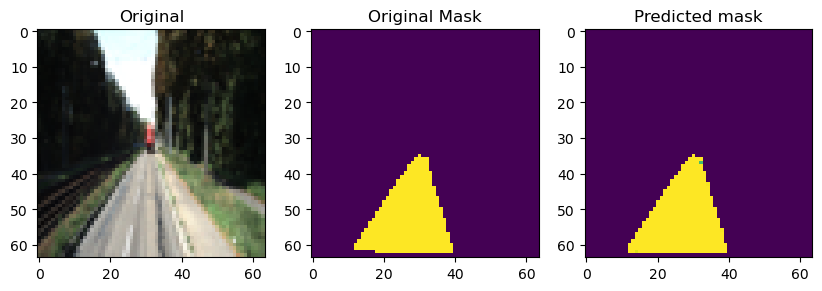

In [35]:
# test cases - I
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1, 2, 0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1, 2, 0))
ax[1].set_title("Original Mask")


ax[2].imshow(prediction[0].transpose(1, 2, 0))
ax[2].set_title("Predicted mask")

plt.show()

In [36]:
@torch.no_grad()
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()
    masks = []
    losses = []

    for input, mask in data_loader:
        mask = mask.to(device)
        input = input.to(device)
        outputs = model(input.float())

        masks.append(outputs.cpu().detach().numpy())

        loss = loss_fn(outputs.float(), mask.float())
        losses.append(loss.item())

    return np.mean(losses), masks

In [37]:
loss, masks = get_predicted_masks(model, test_loader, loss_fn, device)
print(f'Test Loss: {loss}')

Test Loss: 0.03232671022415161


In [38]:
predicted_masks = np.array(masks[0])
for idx in range(1, len(masks)):
    predicted_masks = np.vstack((predicted_masks, masks[idx]))

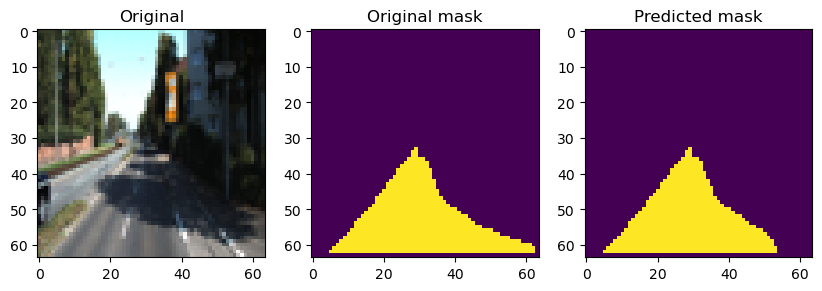

In [39]:
# test case - II
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[12].transpose(1, 2, 0))
ax[0].set_title("Original")

ax[1].imshow(y_test[12].transpose(1, 2, 0))
ax[1].set_title("Original mask")

ax[2].imshow(predicted_masks[12].transpose(1, 2, 0))
ax[2].set_title("Predicted mask")

plt.savefig('predicted-1.png')
plt.show()

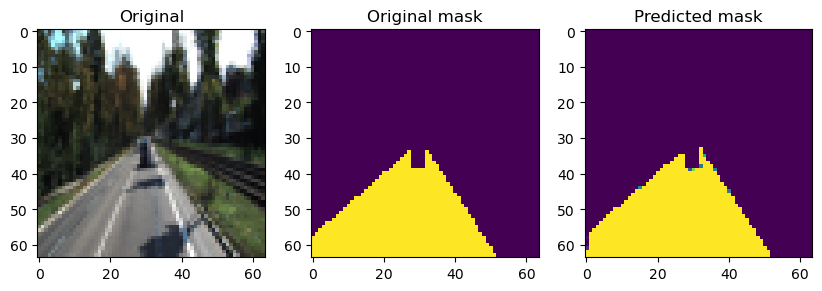

In [40]:
# test case - III
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[124].transpose(1, 2, 0))
ax[0].set_title("Original")

ax[1].imshow(y_test[124].transpose(1, 2, 0))
ax[1].set_title("Original mask")

ax[2].imshow(predicted_masks[124].transpose(1, 2, 0))
ax[2].set_title("Predicted mask")

plt.savefig('predicted-2.png')
plt.show()

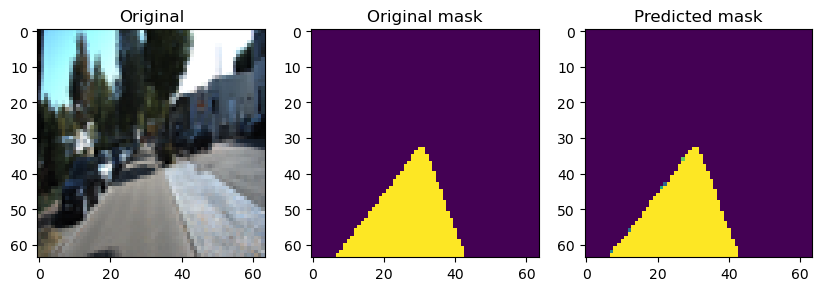

In [41]:
# test case - IV
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[-124].transpose(1, 2, 0))
ax[0].set_title("Original")

ax[1].imshow(y_test[-124].transpose(1, 2, 0))
ax[1].set_title("Original mask")

ax[2].imshow(predicted_masks[-124].transpose(1, 2, 0))
ax[2].set_title("Predicted mask")

plt.savefig('predicted-3.png')
plt.show()

In [48]:
def calculate_metrics(predictions, targets, num_classes):
    """
    Calculate pixel accuracy and mean Intersection over Union (IoU) for semantic segmentation.

    Args:
        predictions (numpy.ndarray): Predicted segmentation masks (integer labels).
        targets (numpy.ndarray): Ground truth segmentation masks (integer labels).
        num_classes (int): Number of classes (excluding background).

    Returns:
        float: Pixel accuracy.
        float: Mean Intersection over Union (IoU).
    """
    # Convert predictions and targets to integer arrays
    predictions = predictions.astype(np.int32)
    targets = targets.astype(np.int32)

    # Calculate pixel accuracy
    pixel_accuracy = np.sum(predictions == targets) / \
        np.prod(predictions.shape)

    # Calculate IoU for each class
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    for i in range(num_classes):
        pred_mask = predictions == i
        target_mask = targets == i
        intersection[i] = np.logical_and(pred_mask, target_mask).sum()
        union[i] = np.logical_or(pred_mask, target_mask).sum()

    # Calculate mean IoU
    class_iou = intersection / union
    mean_iou = np.mean(class_iou)

    return pixel_accuracy, mean_iou


# Assuming predictions and targets are numpy arrays representing predicted masks and ground truth masks
pixel_accuracy, mean_iou = calculate_metrics(predicted_masks, y_test, 1)
print(f'Pixel Accuracy: {pixel_accuracy}')
print(f'Mean IoU: {mean_iou}')

Pixel Accuracy: 0.9945363011853449
Mean IoU: 0.9935599165017329
